In [65]:
import cv2
import numpy as np
import scipy
from scipy import signal
from PIL import Image
import numpy as np
from scipy.signal import convolve
import matplotlib.pyplot as plt
import sys
from scipy.ndimage import minimum_filter1d
np.set_printoptions(threshold=sys.maxsize)
import math

In [2]:
## Cost function

def adjust_cost(image, iteration):
    prev_image = image
    laplacian = np.array([[0, 1, 0],[1, -4, 1],[0, 1, 0]])
    array = image
    rot = 0
    for i in range(0, iteration):
        res = np.abs(convolve(array, laplacian, 'same'))
        rows = res.shape[0]
        colomn = res.shape[1]
        cost = []
        for r in range(0, rows):
            cost.append(np.sum(res[r]))
        cost = np.array(cost)
        min_cost = np.argmin(cost)
        array = np.delete(res, min_cost, axis=0)
        prev_image = np.delete(prev_image, min_cost, axis=0)
        array = np.rot90(array, 1)
        prev_image = np.rot90(prev_image, 1)
        rot += 1
    inv_rot = 4 - rot%4
    prev_image = np.rot90(prev_image, inv_rot)
    
    return prev_image

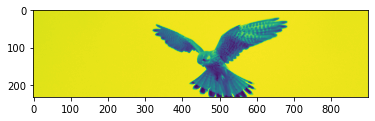

In [42]:
image = np.array(Image.open('C:/Users/HP/Desktop/Jupyter_notebook_files/Computer_vision/Ex_02/additional-data/additional-data/common-kestrel.jpg').convert('L'))
new_imge = adjust_cost(image, 2200)
plt.imshow(new_imge)
plt.show()

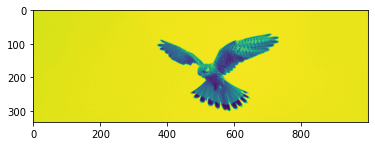

In [36]:
image = np.array(Image.open('C:/Users/HP/Desktop/Jupyter_notebook_files/Computer_vision/Ex_02/additional-data/additional-data/common-kestrel.jpg').convert('L'))
new_imge = adjust_cost(image, 2000)
plt.imshow(new_imge)
plt.show()

In [43]:
new_imge.shape

(233, 900)

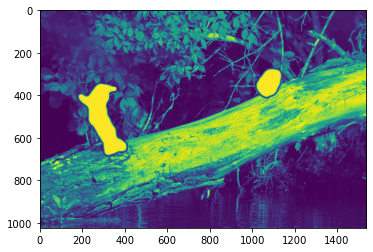

In [2]:
## Masking
## https://gabrijel-boduljak.com/image-seam-carving/
image2 = np.array(Image.open('C:/Users/HP/Desktop/Jupyter_notebook_files/Computer_vision/Ex_02/additional-data/additional-data/kingfishers.jpg').convert('L'))
mask_image = np.array(Image.open('C:/Users/HP/Desktop/Jupyter_notebook_files/Computer_vision/Ex_02/additional-data/additional-data/kingfishers-mask.png').convert('L'))
im_with_mask = mask_image.copy()
im_with_mask[mask_image==0] = image2[mask_image==0]
plt.imshow(im_with_mask)
plt.show()

In [4]:
im_with_mask.shape

(1024, 1536)

In [3]:
def compute_optimal_seam(energy):
    rows, cols = energy.shape
    maxsize = sys.maxsize
    infinity = maxsize / 10
    dp = energy.copy()

    next_seam_position = np.zeros_like(dp, dtype=np.intp)

    for col in range(cols):
        dp[rows - 1][col] = energy[rows-1][col]

    for row in range(rows-2, -1, -1):
        for col in range(cols):
            optimal_adjacent_cost = infinity
            optimal_choice = -1
            adjacents = [
                ((row + 1, col - 1), 1), ##'DIAGONAL_LEFT'
#                 ((row - 1, col), 0),     ##'DOWN' up
                ((row + 1, col + 1), 2), ##'DIAGONAL_RIGHT'
            ]

            for (adjacent, choice) in adjacents:
                adjacent_row, adjacent_col = adjacent
                if adjacent_row!=rows and adjacent_col!=cols and adjacent_row>0 and adjacent_col>0:
                    #continue
                    if dp[adjacent_row][adjacent_col] < optimal_adjacent_cost:
                        optimal_adjacent_cost = dp[adjacent_row][adjacent_col]
                        optimal_choice = choice

            next_seam_position[row][col] = optimal_choice
            dp[row][col] = energy[row][col] + optimal_adjacent_cost

    return dp, next_seam_position

In [99]:
def find_low_cost_seam(dp, next_seam_position, mask):
    rows, cols = dp.shape[0], dp.shape[1]
    maxsize = sys.maxsize
    infinity = maxsize / 10
    ## making seam_list
    start_seam = dp[0][0]
    end_seam = dp[0][cols-1]
    seam_cost = []
    for c in range(cols):
        cost = dp[0][c]
        for r in range(rows):
            ## next_pos 
            if (next_seam_position[r][c] == 0):
                break
            if (next_seam_position[r][c] == 1):
                r = r + 1
                next_pos = (r, c - 1)
            elif (next_seam_position[r][c] == 2):
                r = r + 1
                next_pos = (r, c + 1)
            else:
                r = r + 1
                next_pos = (r, c)
            cost = dp[r][c] + cost
        seam_cost.append(cost)

    seam_start_col = np.argmin(np.array(seam_cost))
    while (mask[:,seam_start_col] > 0).any():
        seam_cost[seam_start_col] = infinity
        seam_start_col = np.argmin(np.array(seam_cost))
        
    seam_start = (0, seam_start_col)
    min_seam_cost = seam_cost[seam_start_col]
    return seam_start, min_seam_cost
    

In [101]:
def trace_seam(original_image, mask, gray_img, energy_image, seam_start, next_seam_position, mask2, sampling):
    seam_pos = seam_start
    original_row = gray_img.shape[0] 
    original_col = gray_img.shape[1]
    while True:
        row, col = seam_pos
        mask[row][col] = 255
        if sampling == 'down':
            for c in range(col, original_col-1):
                gray_img[row][c] = gray_img[row][c+1]
                original_image[row][c][0] = original_image[row][c+1][0]
                original_image[row][c][1] = original_image[row][c+1][1]
                original_image[row][c][2] = original_image[row][c+1][2]
                mask2[row][col] = 255
        elif sampling == 'up':
            gray_img[row][col] = math.ceil((gray_img[row][col] + gray_img[row][col+1] + gray_img[row][col-1])/3)
            original_image[row][col][0] = math.ceil((original_image[row][col][0] + original_image[row][col+1][0] + original_image[row][col-1][0])/3)
            original_image[row][col][1] = math.ceil((original_image[row][col][1] + original_image[row][col+1][1] + original_image[row][col-1][1])/3)
            original_image[row][col][2] = math.ceil((original_image[row][col][2] + original_image[row][col+1][2] + original_image[row][col-1][2])/3)
    
            for c in range(original_col-1, col, -1):
                gray_img[row][c] = int(gray_img[row][c-1])
                original_image[row][c][0] = int(original_image[row][c-1][0])
                original_image[row][c][1] = int(original_image[row][c-1][1])             
                original_image[row][c][2] = int(original_image[row][c-1][2])
                
        if (next_seam_position[row][col] == 0):
            break
        if (next_seam_position[row][col] == 1):
            seam_pos = (row + 1, col - 1)
        elif (next_seam_position[row][col] == 2):
            seam_pos = (row + 1, col + 1)
        else:
            seam_pos = (row + 1, col)
    return original_image.astype(int), gray_img.astype(int), mask, mask2
        

In [98]:
def dijkstra(original_image, gray_img, mask, iteration, sampling):

    mask2 = mask.copy()
    for i in range(0, iteration):      
        im_with_mask = mask.copy()
        im_with_mask[mask==0] = gray_img[mask==0]
        row = im_with_mask.shape[0]
        for i in range(0, row):
            cost = minimum_filter1d(im_with_mask[i], size=3, mode = 'reflect').reshape(1,-1)
            cumulative_cost = cost if i==0 else np.append(cumulative_cost, cost, axis=0) 
        dp, next_seam_position = compute_optimal_seam(cumulative_cost)
        seam_start, min_seam_cost = find_low_cost_seam(dp, next_seam_position, mask)
        original_row = gray_img.shape[0]
        if sampling == 'up':
            a = np.zeros((original_row,1))
            b = np.zeros((original_row,1,3))
            gray_img = np.append(gray_img, a, axis=1)
            original_image = np.append(original_image, b, axis=1)
            original_image, gray_img, processed_mask, mask2 = trace_seam(original_image, mask, gray_img, cumulative_cost, seam_start, next_seam_position, mask2, sampling)
            mask = np.append(processed_mask, a, axis=1)
        
        elif sampling == 'down':
            original_image, gray_img, processed_mask, mask2 = trace_seam(original_image, mask, gray_img, cumulative_cost, seam_start, next_seam_position, mask2, sampling)
            original_col_index = gray_img.shape[1] - 1
            gray_img = np.delete(gray_img, original_col_index, 1)
            original_image = np.delete(original_image, original_col_index, 1)
            mask = np.delete(processed_mask, original_col_index, 1)

    return original_image, mask2


<ipython-input-3-c758abb326ab>:31: RuntimeWarning: overflow encountered in ubyte_scalars
  dp[row][col] = energy[row][col] + optimal_adjacent_cost
<ipython-input-99-67e40803409a>:24: RuntimeWarning: overflow encountered in ubyte_scalars
  cost = dp[r][c] + cost


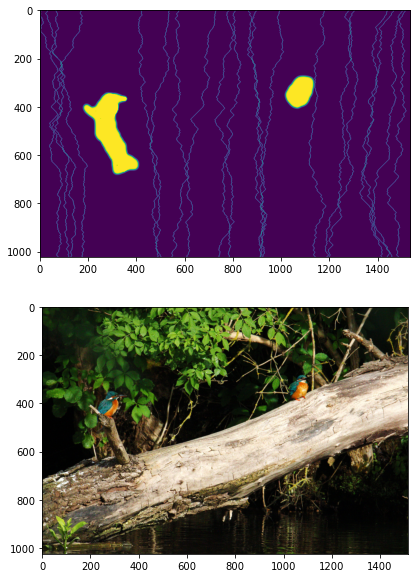

In [106]:
link = 'C:/Users/HP/Desktop/Jupyter_notebook_files/Computer_vision/Ex_02/additional-data/additional-data/kingfishers.jpg'
original_image = np.array(Image.open(link))
gray_img = np.array(Image.open(link).convert('L'))
mask = np.array(Image.open('C:/Users/HP/Desktop/Jupyter_notebook_files/Computer_vision/Ex_02/additional-data/additional-data/kingfishers-mask.png').convert('L'))

edited_image, mask2 = dijkstra(original_image, gray_img, mask, 20, sampling = 'down')
fig, ax = plt.subplots(2, figsize = (10,10))
ax[0].imshow(mask2)
ax[1].imshow(edited_image)
plt.show()

In [107]:
print(gray_img.shape)
print(edited_image.shape)

(1024, 1536)
(1024, 1516, 3)


<ipython-input-3-c758abb326ab>:31: RuntimeWarning: overflow encountered in ubyte_scalars
  dp[row][col] = energy[row][col] + optimal_adjacent_cost
<ipython-input-99-67e40803409a>:24: RuntimeWarning: overflow encountered in ubyte_scalars
  cost = dp[r][c] + cost


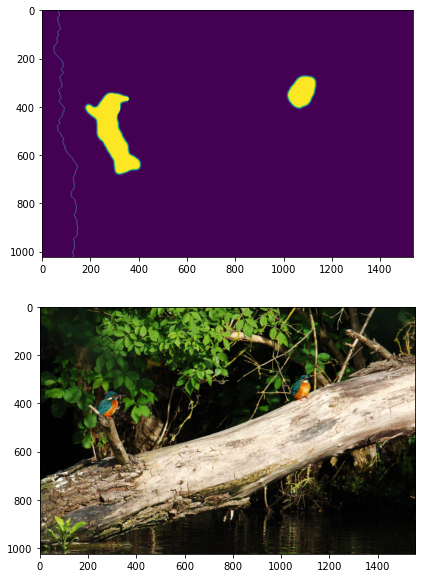

In [108]:
## up sampling
edited_image2, mask2 = dijkstra(original_image, gray_img, mask, 20, sampling = 'up')
fig, ax = plt.subplots(2, figsize = (10,10))
ax[0].imshow(mask2)
ax[1].imshow(edited_image2)
plt.show()

In [110]:
print(gray_img.shape)
print(edited_image2.shape)

(1024, 1536)
(1024, 1556, 3)
